In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [19]:
# Load Social Network Ads dataset
df = pd.read_csv("Social_Network_Ads.csv")
display(df)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [3]:
# Drop irrelevant columns if present
df = df.drop(columns=[col for col in ['User ID'] if col in df.columns])


In [4]:
# Display class distribution
total = len(df)
purchased = df['Purchased'].sum()
not_purchased = total - purchased
print(f"Purchased: {purchased} ({(purchased/total)*100:.2f}%)")
print(f"Not Purchased: {not_purchased} ({(not_purchased/total)*100:.2f}%)")


Purchased: 143 (35.75%)
Not Purchased: 257 (64.25%)


In [5]:
# Define features and target
X = df[['Age', 'EstimatedSalary']]
y = df['Purchased']

In [6]:
# Identify column types
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = []  # No categorical columns in this dataset


In [7]:
# Preprocessing pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [8]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols)
])


In [9]:
# Apply preprocessing
X_processed = preprocessor.fit_transform(X)


In [10]:
# Convert to DataFrame for readability
X_processed_df = pd.DataFrame(X_processed, columns=num_cols)


In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed_df.values, y.values, test_size=0.25, random_state=42)



KNN Results:
Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        63
           1       0.89      0.92      0.91        37

    accuracy                           0.93       100
   macro avg       0.92      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



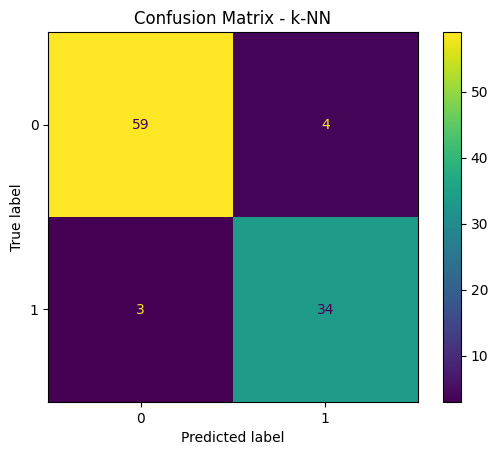

In [12]:
# --- k-NN from scratch ---
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

class KNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_labels = [self.y_train[i] for i in k_indices]
        return max(set(k_labels), key=k_labels.count)

# Train and evaluate k-NN
knn = KNN(k=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("\nKNN Results:")
print("Accuracy:", np.mean(y_pred_knn == y_test))
print(classification_report(y_test, y_pred_knn))
cm_knn = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(cm_knn).plot()
plt.title("Confusion Matrix - k-NN")
plt.show()


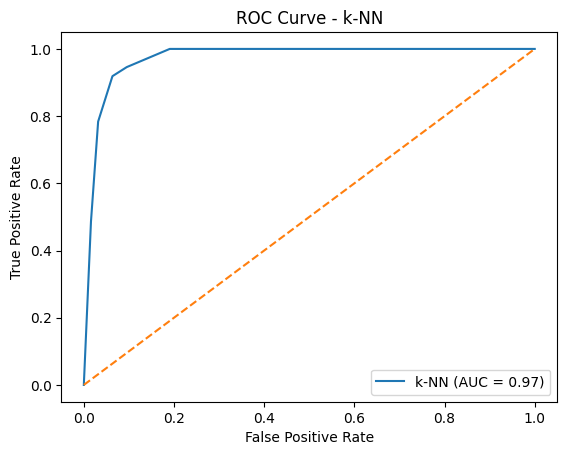

In [13]:
# ROC Curve for k-NN (approximate probabilities using distances)
def knn_predict_proba(model, X):
    probs = []
    for x in X:
        distances = [euclidean_distance(x, x_train) for x_train in model.X_train]
        k_indices = np.argsort(distances)[:model.k]
        k_labels = [model.y_train[i] for i in k_indices]
        proba = sum(k_labels) / model.k
        probs.append(proba)
    return np.array(probs)

knn_probs = knn_predict_proba(knn, X_test)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.plot(fpr_knn, tpr_knn, label=f"k-NN (AUC = {roc_auc_knn:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve - k-NN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



SVM Results:
Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.84      0.98      0.91        63
           1       0.96      0.68      0.79        37

    accuracy                           0.87       100
   macro avg       0.90      0.83      0.85       100
weighted avg       0.88      0.87      0.86       100



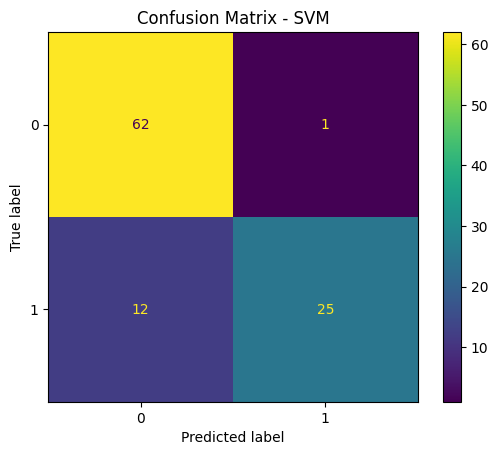

In [14]:
# --- SVM from scratch ---
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, xi in enumerate(X):
                condition = y_[idx] * (np.dot(xi, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(xi, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def decision_function(self, X):
        return np.dot(X, self.w) - self.b

    def predict(self, X):
        return np.where(self.decision_function(X) >= 0, 1, 0)

# Train and evaluate SVM
svm = SVM()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("\nSVM Results:")
print("Accuracy:", np.mean(y_pred_svm == y_test))
print(classification_report(y_test, y_pred_svm))
cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm_svm).plot()
plt.title("Confusion Matrix - SVM")
plt.show()


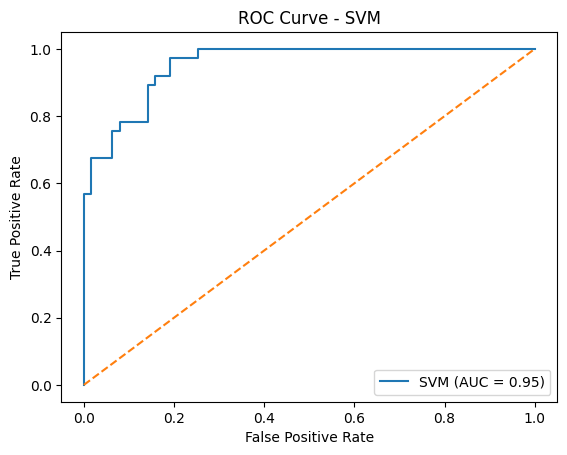

In [15]:
# ROC Curve for SVM using decision function
svm_scores = svm.decision_function(X_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve - SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


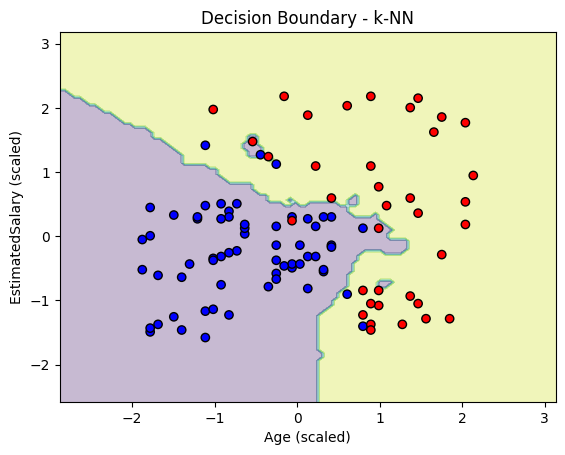

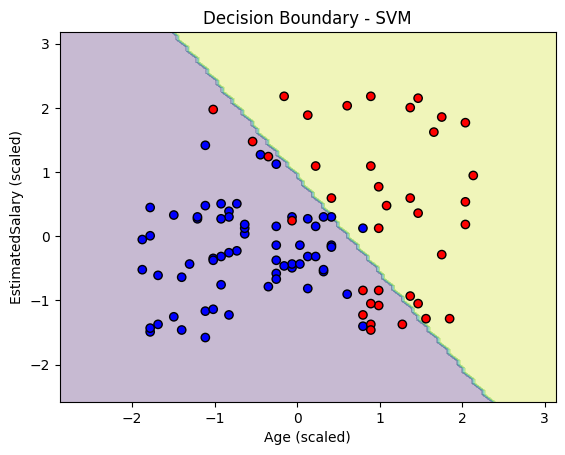

In [16]:
# Optional: Visualize decision boundaries
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
    plt.title(title)
    plt.xlabel('Age (scaled)')
    plt.ylabel('EstimatedSalary (scaled)')
    plt.show()

plot_decision_boundary(knn, X_test, y_test, "Decision Boundary - k-NN")
plot_decision_boundary(svm, X_test, y_test, "Decision Boundary - SVM")


/tmp/ipython-input-17-1492403026.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_analysis.groupby(['AgeGroup', 'SalaryGroup'])['Purchased'].sum().reset_index()


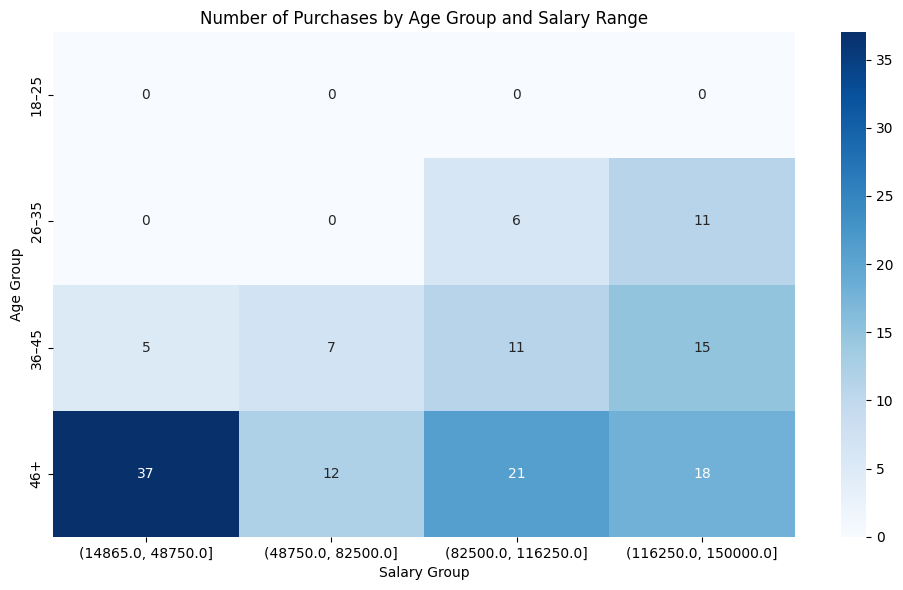

In [17]:
import seaborn as sns
# --- Conclusion Analysis: Influence of Social Media Ads ---

# Reload original data for grouped analysis
df_analysis = pd.read_csv("Social_Network_Ads.csv")

# Drop User ID if it exists
if 'User ID' in df_analysis.columns:
    df_analysis.drop(columns=['User ID'], inplace=True)

# Add age and salary groups
df_analysis['AgeGroup'] = pd.cut(df_analysis['Age'], bins=[15, 25, 35, 45, 60], labels=['18–25', '26–35', '36–45', '46+'])
df_analysis['SalaryGroup'] = pd.cut(df_analysis['EstimatedSalary'], bins=4)

# Group by age and salary bins and count purchases
grouped = df_analysis.groupby(['AgeGroup', 'SalaryGroup'])['Purchased'].sum().reset_index()

# Pivot the data for heatmap
pivot = grouped.pivot(index='AgeGroup', columns='SalaryGroup', values='Purchased')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap='Blues', fmt='g')
plt.title("Number of Purchases by Age Group and Salary Range")
plt.xlabel("Salary Group")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()
